 # Import required packages



In [1]:

import ee
import geemap
import geojson
import lightgbm as lgb
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.interpolate
import shap
from plotly import graph_objects as go
from sklearn.model_selection import train_test_split


In [2]:

ee.Authenticate()
ee.Initialize()


 # Exploratory Data Analysis (EDA)



 ## Data Collection



 Dataset used:



 - [Global Flood Database v1 (2000-2018)](https://developers.google.com/earth-engine/datasets/catalog/GLOBAL_FLOOD_DB_MODIS_EVENTS_V1#description)

 - [USGS Landsat 7 Level 2, Collection 2, Tier 1 ](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C02_T2_L2#description)

 - [SRTM Digital Elevation Data Version 4 ](https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4)



In [3]:

flood_collection: ee.ImageCollection = ee.ImageCollection(
    "GLOBAL_FLOOD_DB/MODIS_EVENTS/V1"
)

landsat_collection: ee.ImageCollection = ee.ImageCollection(
    "LANDSAT/LE07/C02/T1_L2"
).filterDate("2000-02-17", "2018-12-10")
elevation_image = ee.Image("CGIAR/SRTM90_V4")

print("Image structure of each collection:")
display(flood_collection.first(), landsat_collection.first(), elevation_image)


Image structure of each collection:


 Mask the images with conditions:



 - Clear percentage of flood images **>= 0.5**

 - **Not** permanent water



In [4]:

def mask_flood(image):
    clear_perc_mask = image.select("clear_perc").gte(0.5)  # Clear percentage >= 50%
    jrc_perm_water_mask = image.select("jrc_perm_water").eq(
        0
    )  # 0 - non-water | 1 - permanent water

    combined_mask = clear_perc_mask.And(jrc_perm_water_mask)

    masked_image = image.updateMask(combined_mask)

    return masked_image


flood_collection = flood_collection.map(mask_flood)


 Compose the following bands into an image collection:



 - **_x_**, **_y_**, _elevation_ as **_z_** and **_slope_**

 - **_SR_B1, SR_B2, SR_B3, SR_B4, SR_B5, SR_B7_** from Landsat Collection

 - **_NDWI_** calculated using SR_B2 and SR_B4

 - **_duration, clear_perc, flooded_** from Global Flood Database



In [5]:

landsat_interest_bands = ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"]
flood_interest_bands = ["duration", "clear_perc", "flooded"]

elevation = elevation_image.select("elevation").rename("z")
slope = ee.Terrain.slope(elevation_image)


def filter_single_scene(image):
    date_range = ee.DateRange(
        image.get("system:time_start"), image.get("system:time_end")
    )
    return ee.Algorithms.If(
        date_range.end().difference(date_range.start(), "days").gt(0), image, None
    )


def compose_landsat(image):
    geometry = image.geometry()
    date_range = ee.DateRange(
        image.get("system:time_start"), image.get("system:time_end")
    )
    landsat_image = (
        landsat_collection.select(ee.List(landsat_interest_bands))
        .filterDate(date_range.start(), date_range.end())
        .filterBounds(geometry)
        .median()
    )
    return ee.Algorithms.If(
        landsat_image.bandNames().length(),
        image.select(flood_interest_bands).addBands(
            landsat_image,
            ee.List(landsat_interest_bands),
        ),
        None,
    )


def add_elevation_bands(image: ee.Image):
    return image.addBands(elevation).addBands(slope)


def add_ndwi_band(image: ee.Image):
    ndwi = image.normalizedDifference(["SR_B2", "SR_B4"]).rename("ndwi")
    return image.addBands(ndwi, ["ndwi"])


def set_default_projection(image: ee.Image):
    projection = image.select("flooded").projection()
    return image.setDefaultProjection(projection)


images = (
    flood_collection.map(filter_single_scene, True)
    .map(compose_landsat, True)
    .map(add_elevation_bands)
    .map(add_ndwi_band)
    .map(set_default_projection)
)
print(f"Number of flood event images left: {images.size().getInfo()}")
images.first()


Number of flood event images left: 848


In [6]:

def to_features(image: ee.Image):
    # Reduce resolution of bands to a common scale
    image = image.addBands(
        image.select([*landsat_interest_bands, "ndwi", "z"]).reduceResolution(
            reducer=ee.Reducer.mean()
        ),
        overwrite=True,
    )
    return image.stratifiedSample(
        classBand="flooded",
        numPoints=50,
        dropNulls=True,
        scale=250,
        tileScale=4,
        region=image.geometry(),
        geometries=False,
        projection=image.projection(),
    )


dataset = (
    images.select(
        [*landsat_interest_bands, *flood_interest_bands, "ndwi", "z", "slope"]
    )
    .map(to_features)
    .flatten()
)


In [7]:

# geemap.ee_export_vector_to_drive(dataset, description="flood_dataset", fileFormat="csv")


 Extract the details of flood events



In [8]:

interest_properties = {
    "system:index": "id",
    "dfo_country": "primary_country",
    "dfo_severity": "severity",
    "system:time_start": "start_date",
    "system:time_end": "end_date",
    "dfo_centroid_x": "center_lon",
    "dfo_centroid_y": "center_lat",
    "dfo_main_cause": "main_cause",
    "dfo_dead": "dead",
    "dfo_displaced": "displaced",
}


def extract_properties(image):
    old_keys = ee.List(list(interest_properties.keys()))
    new_keys = ee.List(list(interest_properties.values()))
    props: ee.Dictionary = image.toDictionary(old_keys).rename(old_keys, new_keys, True)
    mask = image.select("flooded").gt(0)
    area = (
        ee.Image.pixelArea()
        .mask(mask)
        .reduceRegion(
            reducer=ee.Reducer.sum(),
            scale=250,
            geometry=image.geometry(),
            maxPixels=412598311,
            crs=image.projection(),
        )
    ).get("area")
    props = props.set("area", area)
    return ee.Feature(None, props)


flood_properties = ee.FeatureCollection(flood_collection.map(extract_properties))


In [9]:

geemap.ee_to_csv(flood_properties, filename="data/asg3/flood_props.csv")


 ## Data Cleaning



 Checking for data distribution and null entry



In [10]:

df_flood_props = pd.read_csv("data/asg3/flood_props.csv", index_col="id").reset_index()
display(df_flood_props.head(), df_flood_props.describe(), df_flood_props.isna().sum())


id          area  center_lat  center_lon  \
0  DFO_1586_From_20000218_to_20000301  3.167333e+08  -31.268059  143.697800   
1  DFO_1587_From_20000217_to_20000311  2.502000e+08  -15.782624   47.295670   
2  DFO_1595_From_20000405_to_20000425  8.910377e+07   46.763746   22.415404   
3  DFO_1614_From_20000711_to_20000810  4.397571e+09   11.242567  105.063841   
4  DFO_1627_From_20000830_to_20000910  9.194628e+08   43.773883  132.057679   

   dead  displaced      end_date        main_cause primary_country  severity  \
0     1        200  951868800000    Monsoonal rain       Australia       2.0   
1   200     800000  952732800000  Tropical cyclone      Madagascar       1.0   
2    10        623  956620800000          Snowmelt         Romania       2.0   
3    33      25000  965865600000    Monsoonal rain        Thailand       1.0   
4    31      14140  968544000000  Tropical cyclone           China       1.0   

     start_date  
0  950832000000  
1  950745600000  
2  954892800000  
3  963273600000  
4  967593600000

area  center_lat  center_lon           dead     displaced  \
count  9.130000e+02  913.000000  913.000000     913.000000  9.130000e+02   
mean   6.953646e+09   15.395235   38.340958     180.046002  2.674868e+05   
std    1.188170e+10   24.050427   78.687131    3332.691202  1.995806e+06   
min    0.000000e+00  -45.953281 -156.215507       0.000000  0.000000e+00   
25%    7.060815e+08    0.058024  -13.967824       0.000000  3.000000e+01   
50%    2.223036e+09   18.877688   55.552555       5.000000  3.500000e+03   
75%    7.381296e+09   32.886368  103.415798      27.000000  4.000000e+04   
max    9.854770e+10   68.000870  178.075692  100000.000000  4.000000e+07   

           end_date    severity    start_date  
count  9.130000e+02  913.000000  9.130000e+02  
mean   1.224903e+12    1.297371  1.223187e+12  
std    1.472525e+11    0.392520  1.474857e+11  
min    9.518688e+11    1.000000  9.507456e+11  
25%    1.103328e+12    1.000000  1.102291e+12  
50%    1.197245e+12    1.000000  1.195085e+12  
75%    1.330301e+12    1.500000  1.329696e+12  
max    1.544400e+12    2.000000  1.543968e+12

id                 0
area               0
center_lat         0
center_lon         0
dead               0
displaced          0
end_date           0
main_cause         0
primary_country    0
severity           0
start_date         0
dtype: int64

In [11]:

df_flood_data = pd.read_csv(
    "data/asg3/flood_dataset.csv", index_col="system:index"
).reset_index()
display(df_flood_data.head(), df_flood_data.describe(), df_flood_data.isna().sum())


system:index    SR_B1    SR_B2    SR_B3    SR_B4  \
0  DFO_1586_From_20000218_to_20000301_0  38182.0  29077.0  34219.0  22596.0   
1  DFO_1586_From_20000218_to_20000301_1  10304.0  12775.0  16730.0  20689.0   
2  DFO_1586_From_20000218_to_20000301_2  14348.0  17113.0  19445.0  20881.0   
3  DFO_1586_From_20000218_to_20000301_3  65535.0  65535.0  65535.0  31902.0   
4  DFO_1586_From_20000218_to_20000301_4  12960.0  13637.0  14640.0  16029.0   

     SR_B5    SR_B7  clear_perc  duration  flooded      ndwi     slope      z  \
0  21604.0  18202.0         1.0         0        0  0.125423  1.317596  119.0   
1  24540.0  21194.0         1.0         0        0 -0.236493  0.154581  151.0   
2  24473.0  22067.0         1.0         0        0 -0.099174  0.000000   29.0   
3  25274.0  20551.0         1.0         0        0  0.345177  1.292620   47.0   
4  16719.0  14145.0         1.0         0        0 -0.080631  0.240548   65.0   

                                     .geo  
0  {"type":"MultiPoint","coordinates":[]}  
1  {"type":"MultiPoint","coordinates":[]}  
2  {"type":"MultiPoint","coordinates":[]}  
3  {"type":"MultiPoint","coordinates":[]}  
4  {"type":"MultiPoint","coordinates":[]}

SR_B1         SR_B2         SR_B3         SR_B4         SR_B5  \
count  80354.000000  80354.000000  80354.000000  80354.000000  80354.000000   
mean   20092.456841  19307.969585  20190.967046  19047.787428  15720.140640   
std    18827.824469  16747.044276  17624.727589   9175.595795   7648.333485   
min     1347.000000   3866.500000   5128.500000   5953.000000   6992.500000   
25%     9200.000000   9996.000000   9938.000000  12922.750000  10818.000000   
50%    10993.000000  12044.000000  12450.000000  17228.750000  14452.000000   
75%    18317.000000  18206.375000  19191.750000  22198.000000  18196.875000   
max    65535.000000  65535.000000  65535.000000  65535.000000  65535.000000   

              SR_B7    clear_perc      duration       flooded          ndwi  \
count  80354.000000  80354.000000  80354.000000  80354.000000  80354.000000   
mean   13064.029526      0.983093      2.359957      0.487891     -0.063395   
std     4669.589228      0.028030      5.200521      0.499856      0.173900   
min     7201.000000      0.625000      0.000000      0.000000     -0.554557   
25%     9401.625000      0.972222      0.000000      0.000000     -0.178965   
50%    11975.000000      1.000000      0.000000      0.000000     -0.075776   
75%    15736.000000      1.000000      3.000000      1.000000      0.006769   
max    65535.000000      1.000000    145.000000      1.000000      0.537117   

              slope             z  
count  80354.000000  80354.000000  
mean       1.249266    385.527740  
std        2.410576    761.573009  
min        0.000000   -123.000000  
25%        0.221696     26.000000  
50%        0.490689    135.000000  
75%        1.305663    372.000000  
max       50.952850   6616.000000

system:index    0
SR_B1           0
SR_B2           0
SR_B3           0
SR_B4           0
SR_B5           0
SR_B7           0
clear_perc      0
duration        0
flooded         0
ndwi            0
slope           0
z               0
.geo            0
dtype: int64

In [12]:

with open("countries.geojson") as f:
    countries_boundary = geojson.load(f)

countries_ADM = [
    feature["properties"]["ADMIN"] for feature in countries_boundary["features"]
]


 Verify all country is valid with ADM standard



In [13]:

def check_country_exists_ADM(countries):
    return pd.DataFrame(
        {
            "primary_country": countries,
            "exists_in_ADM": countries.isin(countries_ADM),
        }
    )


df_temp = check_country_exists_ADM(
    pd.Series(df_flood_props["primary_country"].unique())
)
df_temp[df_temp["exists_in_ADM"] == False]


primary_country  exists_in_ADM
14                            USA          False
18                         Africa          False
23                          Texas          False
24                       Columbia          False
33                          Burma          False
41                             UK          False
66             Bosnia-Herzegovina          False
68                      Venezulea          False
83              Serbia-Montenegro          False
92   Democratic Republic of Congo          False
93                       Tanzania          False
94                      Guatamala          False
97                         Serbia          False
103                          Inda          False
106                      Tasmania          False
109                          Gaza          False
110                      Scotland          False
111                    The Gambia          False
116                    Kazahkstan          False
117                      Uruguay,          False
119                       Bahamas          False

 Transform invalid countries' value according to ADM standard



In [14]:

country_to_adm = {
    "USA": "United States of America",
    "UK": "United Kingdom",
    "Burma": "Myanmar",
    "Tanzania": "United Republic of Tanzania",
    "Columbia": "Colombia",
    "Bosnia-Herzegovina": "Bosnia and Herzegovina",
    "Guatamala": "Guatemala",
    "Serbia": "Republic of Serbia",
    "Africa": "Central African Republic",  # Africa is a continent, not a country
    "Texas": "United States of America",  # Texas is a state in the USA
    "Venezulea": "Venezuela",
    "Serbia-Montenegro": "Republic of Serbia",  # No longer exists as a single country
    "Inda": "India",
    "Democratic Republic of Congo": "Democratic Republic of the Congo",
    "Tasmania": "Australia",  # Tasmania is a state in Australia
    "The Gambia": "Gambia",
    "Scotland": "United Kingdom",  # Scotland is part of the United Kingdom
    "Gaza": "Palestine",  # Gaza is a region in Palestine
    "Kazahkstan": "Kazakhstan",
    "Uruguay,": "Uruguay",
    "Bahamas": "The Bahamas",
}


def process_country_name(country):
    processed_country = country_to_adm.get(country)
    return processed_country if processed_country else country


df_flood_props_cleaned = df_flood_props.copy()
df_flood_props_cleaned["primary_country"] = df_flood_props["primary_country"].apply(
    process_country_name
)
df_temp = check_country_exists_ADM(
    pd.Series(df_flood_props_cleaned["primary_country"].unique())
)
df_temp.sort_values("exists_in_ADM")


primary_country  exists_in_ADM
0             Australia           True
80   Republic of Serbia           True
79             Slovakia           True
78              Ecuador           True
77              Jamaica           True
..                  ...            ...
31                 Iran           True
30              Germany           True
29         South Africa           True
40       United Kingdom           True
110            Mongolia           True

[111 rows x 2 columns]

In [15]:
# df_flood_props_cleaned.to_csv("data/asg3/flood_props_cleaned.csv")


 ## Data Visualization



In [16]:
causes = [x.lower() for x in df_flood_props_cleaned["main_cause"].to_list()]

categories = {
    "Heavy rain": ["rain", "monsoon", "torrential"],
    "Dam break/release": ["dam", "levy", "release"],
    "Snowmelt": ["snow"],
    "Ice jam": ["ice"],
    "Tropical storm": ["tropical", "typhoon", "hurricane"],
}

df_flood_cause = pd.DataFrame(
    data={
        "event": list(categories.keys()) + ["Other"],
        "count": np.zeros(len(categories) + 1, dtype=int),
        "matched": [[] for _ in range(len(categories) + 1)],
    }
)

for event in causes:
    matched = False
    for category, keywords in categories.items():
        if any(keyword in event for keyword in keywords):
            idx = df_flood_cause.index[df_flood_cause["event"] == category].tolist()[0]
            df_flood_cause.at[idx, "count"] += 1
            df_flood_cause.at[idx, "matched"].append(event)
            matched = True
    if not matched:
        idx = df_flood_cause.index[df_flood_cause["event"] == "Other"].tolist()[0]
        df_flood_cause.at[idx, "count"] += 1
        df_flood_cause.at[idx, "matched"].append(event)


fig = px.bar(
    df_flood_cause,
    x="event",
    y="count",
    color="count",
    text="count",
)
fig.update_layout(title=dict(text="Main Cause of Flood Events", x=0.5))
fig.show()
fig = px.pie(
    df_flood_data["flooded"].value_counts().to_frame().reset_index(),
    values="count",
    names=["Non-water", "Flooded"],
)
fig.update_layout(
    title=dict(text="Ratio of Flooded Area Against Non-Water Area in Dataset", x=0.5),
    margin_b = 20
)
fig.show()

 Global flood occurrence (only primary influenced country)

In [17]:
df_flood_by_country = pd.DataFrame(
    df_flood_props_cleaned["primary_country"].value_counts().reset_index(name="counts")
)

scattergeo_trace = go.Scattergeo(
    lat=df_flood_props_cleaned["center_lat"],
    lon=df_flood_props_cleaned["center_lon"],
    mode="markers",
    marker=dict(
        size=12,
        opacity=0.8,
        autocolorscale=False,
        symbol="triangle-down",
        colorscale="Reds",
        cmin=0,
        color=df_flood_props_cleaned["severity"],
        cmax=df_flood_props_cleaned["severity"].max(),
        colorbar_title="Severity",
        colorbar_x=1.15,
    ),
    hoverinfo="skip",
)

choropleth_trace = go.Choropleth(
    locations=df_flood_by_country["primary_country"],
    locationmode="country names",
    z=df_flood_by_country["counts"],
    colorscale="amp",
    colorbar_title="Occurence",
    hoverlabel_namelength=0,
)


fig = go.Figure(data=[scattergeo_trace, choropleth_trace])
fig.data[0].showlegend = False

fig.update_layout(
    title_text="Flood Severity and Occurrence",
    title_x=0.5,
    geo=dict(
        showland=True,
        landcolor="rgb(95, 138, 92)",
        showcountries=True,
        countrycolor="rgb(255, 255, 255)",
        showocean=True,
        oceancolor="rgb(158,202,225)",
        projection_type="orthographic",
    ),
    margin={"b": 15, "l": 20, "r": 0, "t": 70},
    shapes=list(
        [
            dict(
                fillcolor="rgb(95, 138, 92)",
                layer="below",
                line={"dash": "dash"},
                name="Country not primarily <br>affected by flood",
                showlegend=True,
                type="rect",
                xref="paper",
            )
        ]
    ),
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=0,
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=1,
    ),
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [
                        {"geo.projection.type": "orthographic"},
                    ],
                    "label": "Orthographic",
                    "method": "relayout",
                },
                {
                    "args": [
                        {"geo.projection.type": "equirectangular"},
                    ],
                    "label": "Equirectangular",
                    "method": "relayout",
                },
            ],
            "direction": "left",
            "showactive": True,
            "type": "buttons",
            "x": 0,
            "xanchor": "left",
            "y": 1.15,
            "yanchor": "top",
        }
    ],
)
fig.show()

fig = px.scatter(
    df_flood_props_cleaned,
    x="displaced",
    y="dead",
    size="area",
    color="primary_country",
    hover_name="id",
)
fig.update_layout(
    title=dict(text="Estimated Displaced Against Fatalities Due to Flood Event", x=0.5),
    height=750,
)
fig.show()

 Select the image of 2010 Pakistan floods for visualizing



In [18]:
target_flood = "DFO_2507_From_20040620_to_20041007"
max_pixels = 10000
scale = 25000

target_image = (
    images.filter(ee.Filter.eq("system:index", target_flood)).first().unmask()
)

# Extract the image as features (x, y, z, flooded) to investigate the relationship between elevation/slope and flood
target_image_features = ee.FeatureCollection(
    target_image.reduceResolution(reducer=ee.Reducer.mean(), maxPixels=max_pixels)
    .addBands(ee.Image.pixelCoordinates(projection=target_image.projection()))
    .select(["x", "y", "z", "flooded"])
    .reduceRegion(
        ee.Reducer.toCollection(["x", "y", "z", "flooded"]),
        scale=scale,
        geometry=target_image.geometry().bounds(),
        crs=target_image.projection(),
    )
    .get("features")
)

display(target_image)
print(f"Number of points: {target_image_features.size().getInfo()}")


Number of points: 9120


In [19]:
# geemap.ee_to_csv(
#     target_image_features, filename=f"data/asg3/{target_flood}_data.csv"
# )

 Plot 3D DEM of target image with flood area colored



In [20]:
target_image_data = pd.read_csv(f"data/asg3/{target_flood}_data.csv").to_numpy()

flooded = target_image_data[:, 0]
x = target_image_data[:, 1]
y = target_image_data[:, 2]
z = target_image_data[:, -1]

xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xstep, ystep = (
    np.round((xmax - xmin) / np.unique(x).shape).item(),
    np.round((ymax - ymin) / np.unique(y).shape).item(),
)
u = np.arange(start=xmin, stop=xmax, step=xstep)
v = np.arange(start=ymin, stop=ymax, step=ystep)

X, Y = np.meshgrid(u, v)
Z = scipy.interpolate.griddata(
    (x, y), z, (X, Y), method="nearest", fill_value=0, rescale=True
)
F = scipy.interpolate.griddata(
    (x, y), flooded, (X, Y), method="nearest", fill_value=0, rescale=True
)
Fmin, Fmax = np.min(F), np.max(F)
fig = go.Figure(
    data=[
        go.Surface(
            z=Z, colorscale="Plotly3", showscale=True, colorbar_title="Elevation"
        ),
        go.Surface(
            z=Z + 150,
            surfacecolor=F,
            cmin=Fmin,
            cmax=Fmax,
            colorscale=[
                [0, "rgba(7, 148, 242, 0.0)"],
                [0.3, "rgba(7, 148, 242, 1.0)"],
                [1, "rgba(7, 148, 242, 1.0)"],
            ],
            colorbar=dict(title="Flood mean", x=-0.1),
        ),
    ]
)
fig.update_traces(
    contours_z=dict(
        show=True,
        usecolormap=True,
        project_z=True,
        color="rgba(255, 0, 0, 0.5)",
    )
)
fig.update_layout(
    scene_camera_eye=dict(x=1.5, y=1.5, z=1.25),
    margin=dict(l=0, r=0, t=0, b=30),
    title=dict(text=f"3D DEM of {target_flood}", x=0.5, y=0.95),
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(
                    label="Toggle Elevation Surface",
                    method="update",
                    args=[
                        {
                            "visible": [True, True],
                            "contours.z.usecolormap": [True, True],
                        },
                    ],
                    args2=[
                        {
                            "visible": [False, True],
                            "contours.z.usecolormap": [False, False],
                        },
                    ],
                ),
            ],
            direction="left",
            showactive=True,
            x=-0.1,
            xanchor="left",
            y=1.1,
            yanchor="top",
        )
    ],
)
fig.show()


In [21]:
Map = geemap.Map()
Map.add_basemap("HYBRID")

vis_params = {"min": 0, "max": 10, "palette": ["c3effe", "1341e8", "051cb0", "001133"]}

Map.addLayer(
    flood_collection.select("jrc_perm_water").sum().gte(1).selfMask(),
    {"min": 0, "max": 1, "palette": "c3effe"},
    "JRC Permanent Water",
)

Map.addLayer(
    flood_collection.select("flooded").sum().selfMask(),
    vis_params,
    "GFD Satellite Observed Flood Plain",
)

Map.add_colorbar_branca(
    colors=vis_params["palette"],
    vmin=vis_params["min"],
    vmax=vis_params["max"],
    layer_name="",
    caption="Flood occurrence",
    discrete=True,
)

Map.addLayer(
    images.select("flooded").sum().selfMask(),
    vis_params,
    "Masked GFD Satellite Observed Flood Plain",
)

Map.addLayer(
    target_image.select("flooded").selfMask(),
    vis_params,
    "Selected flood event",
)
Map.addLayer(
    ee.FeatureCollection(ee.Feature(target_image.geometry().bounds())).style(
        color="red", fillColor="00000000"
    ),
    {},
    "Selected flood event boundary",
)

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [22]:
features = [
    "SR_B1",
    "SR_B2",
    "SR_B3",
    "SR_B4",
    "SR_B5",
    "SR_B7",
    "slope",
    "z",
    "ndwi",
]
x = df_flood_data[features]
y = df_flood_data["flooded"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)
forest = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=1000,
    learning_rate=0.01,
    deterministic=True,
    device_type="cpu",
    verbose=0
)
forest.fit(X_train, y_train)

LGBMClassifier(deterministic=True, device_type='cpu', learning_rate=0.01,
               n_estimators=1000, objective='binary', verbose=0)

In [23]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_test)

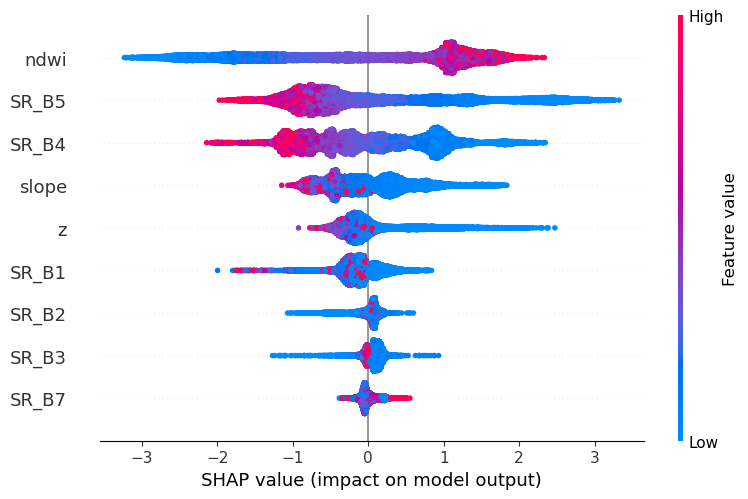

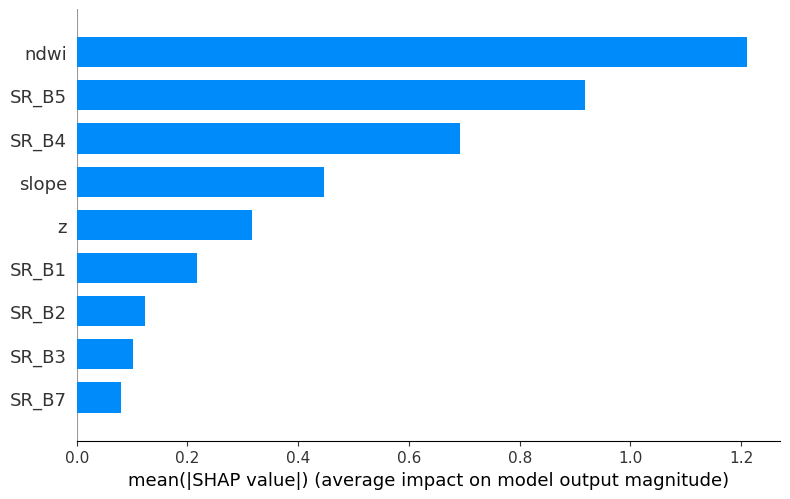

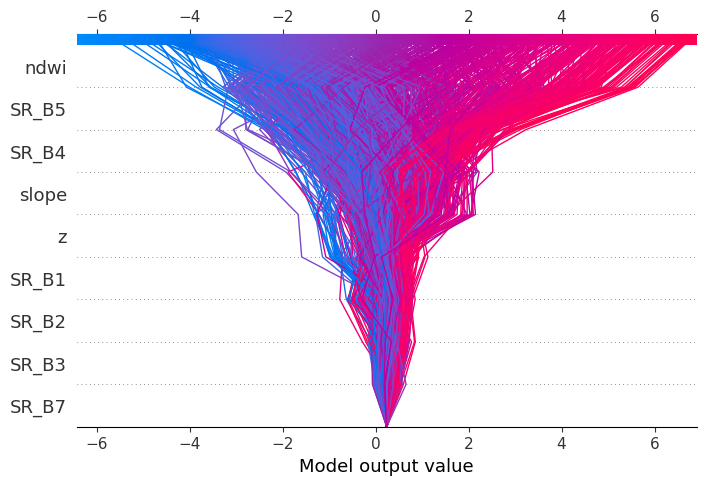

In [38]:
shap.initjs()
from IPython.display import HTML

shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.decision_plot(explainer.expected_value, 
                shap_values[:1000], feature_names=list(X_test.columns))
# , X_test.iloc[0]P
force_plot = shap.force_plot(explainer.expected_value, shap_values[:1000], feature_names=list(X_test.columns))
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")
